# A modular version with LSTMs

written November 2016 by Sam Greydanus

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
import gym
import tensorflow as tf

In [2]:
class Actor():
    def __init__(self, batch_size, tsteps, xlen, ylen):
        self.sess = tf.InteractiveSession()
        self.batch_size = batch_size
        self.xlen = xlen
        self.ylen = ylen
        self.x = x = tf.placeholder(tf.float32, shape=[None, None, xlen], name="x")
        self.y = y = tf.placeholder(tf.float32, shape=[None, None, ylen], name="y")
        
        self.params = params = {}
        self.fc1_size = fc1_size = 50
        self.rnn_size = rnn_size = 100
        with tf.variable_scope('actor',reuse=False):
            xavier_l1 = tf.truncated_normal_initializer(mean=0, stddev=1./np.sqrt(ylen), dtype=tf.float32)
            params['W1'] = tf.get_variable("W1", [xlen, fc1_size], initializer=xavier_l1)

            rnn_init = tf.truncated_normal_initializer(stddev=0.075, dtype=tf.float32)
            params['rnn'] = tf.nn.rnn_cell.LSTMCell(rnn_size, state_is_tuple=True, initializer=rnn_init)

            params['istate_batch'] = params['rnn'].zero_state(batch_size=batch_size, dtype=tf.float32)
            params['istate'] = params['rnn'].zero_state(batch_size=1, dtype=tf.float32)

            xavier_l3 = tf.truncated_normal_initializer(stddev=1./np.sqrt(rnn_size), dtype=tf.float32)
            params['W3'] = tf.get_variable("W3", [rnn_size, ylen], initializer=xavier_l3)
        
        self.reset_state()
            
    def forward(self, x, state, tsteps, reuse=False):
        with tf.variable_scope('actor', reuse=reuse):
            x = tf.reshape(x, [-1, self.xlen])
            h = tf.matmul(x, self.params['W1'])
            h = tf.nn.relu(h) # ReLU nonlinearity
#             h = tf.nn.dropout(h,0.8)

            hs = [tf.squeeze(h_, [1]) for h_ in tf.split(1, tsteps, tf.reshape(h, [-1, tsteps, self.fc1_size]))]
            rnn_outs, state = tf.nn.seq2seq.rnn_decoder(hs, state, self.params['rnn'], scope='actor')
            rnn_out = tf.reshape(tf.concat(1, rnn_outs), [-1, self.rnn_size])
            rnn_out = tf.nn.relu(rnn_out) # ReLU nonlinearity

            logps = tf.matmul(rnn_out, self.params['W3'])
            p = tf.nn.softmax(logps)
            p = tf.reshape(p, [-1, self.ylen])
        return p, state
    
    def reset_state(self):
        self.c, self.h = self.params['istate'].c.eval(), self.params['istate'].h.eval()

In [3]:
class Agent():
    def __init__(self, n_obs, n_actions, gamma=0.99, lr = 1e-4, epsilon = 0.1):
        self.gamma = gamma            # discount factor for reward
        self.epsilon = epsilon
        self.global_step = 0
        self.xs, self.rs, self.ys = [],[],[]
        
        self.lr = lr               # learning rate for policy
        self.n_obs = n_obs                     # dimensionality of observations
        self.n_actions = n_actions             # number of available actions
        
        # make actor part of brain
        self.batch_size = 8
        self.tsteps = 20
        self.actor = Actor(self.batch_size, self.tsteps, self.n_obs, self.n_actions)
        
        #placeholders
        self.x = tf.placeholder(dtype=tf.float32, shape=[None, n_obs],name="x")
        self.y = tf.placeholder(dtype=tf.float32, shape=[None, n_actions],name="y")
        self.r = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="r")
        
        #gradient processing (PG magic)
        self.discounted_r = self.discount_rewards(self.r, self.gamma)
        mean, variance= tf.nn.moments(self.discounted_r, [0], shift=None, name="reward_moments")
        self.discounted_r -= mean
        self.discounted_r /= tf.sqrt(variance + 1e-6)
        
        # initialize tf graph
        self.y_hat, self.actor.params['fstate'] = \
                self.actor.forward(self.x, self.actor.params['istate'], 1, reuse=False)
        self.y_hat_batch, _ = self.actor.forward(self.x, self.actor.params['istate_batch'], self.tsteps, reuse=True)
        
        self.loss = tf.nn.l2_loss(self.y-self.y_hat_batch)
        self.optimizer = tf.train.RMSPropOptimizer(self.lr, decay=0.99)
        self.grads = self.optimizer.compute_gradients(self.loss, \
                                    var_list=tf.trainable_variables(), grad_loss=self.discounted_r)
        self.train_op = self.optimizer.apply_gradients(self.grads)

        self.sess = tf.InteractiveSession()
        tf.initialize_all_variables().run()
        self.saver = tf.train.Saver(tf.all_variables())
        self.actor.reset_state()
    
    def act(self, x):
        feed = {self.x: x, self.actor.params['istate'].c: self.actor.c, self.actor.params['istate'].h: self.actor.h}
        fetch = [self.y_hat, self.actor.params['fstate'].c, self.actor.params['fstate'].h]
        [y_hat, self.actor.c, self.actor.h] = self.sess.run(fetch, feed)
        y_hat = y_hat[0,:]
        if np.random.rand() > 0.99985: print "\ty_hat is: ", y_hat
        action = np.random.choice(self.n_actions,p=y_hat) if np.random.rand() > self.epsilon else np.random.randint(self.n_actions)
        
        label = np.zeros_like(y_hat) ; label[action] = 1
        self.xs.append(x)
        self.ys.append(label)
        return action
    
    def learn(self):
        epx = np.vstack(self.xs)
        epr = np.vstack(self.rs)
        epy = np.vstack(self.ys)
        self.xs, self.rs, self.ys = [],[],[] # reset game history
        
        unit_len = self.batch_size*self.tsteps
        buffer_len = ((unit_len - epx.shape[0]%unit_len)%unit_len)
        epx_buffer = np.zeros((buffer_len,epx.shape[1]))
        epr_buffer = np.zeros((buffer_len,epr.shape[1]))
        epy_buffer = np.zeros((buffer_len,epy.shape[1]))
        
        epx = np.concatenate((epx, epx_buffer),axis=0)
        epr = np.concatenate((epr, epr_buffer),axis=0)
        epy = np.concatenate((epy, epy_buffer),axis=0)
        
        num_batches = epx.shape[0]/unit_len
        for b in range(num_batches):
            start = b*unit_len ; stop = (b+1)*unit_len
            feed = {self.x: epx[start:stop,:], self.r: epr[start:stop,:], self.y: epy[start:stop,:]}
            train_loss, _ = self.sess.run([self.loss, self.train_op],feed) # parameter update
        self.global_step += 1
        return train_loss
        
    @staticmethod
    def discount_rewards(r, gamma):
        discount_f = lambda a, v: (a*gamma + v)*(1-tf.abs(v)) + (v)*tf.abs(v);
        r_reverse = tf.scan(discount_f, tf.reverse(r,[True, False]))
        discounted_r = tf.reverse(r_reverse,[True, False])
        return discounted_r

In [4]:
def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

def plt_dynamic(x, y, ax, colors=['b']):
    for color in colors:
        ax.plot(x, y, color)
    fig.canvas.draw()

In [5]:
n_obs = 80*80   # dimensionality of observations
n_actions = 3
agent = Agent(n_obs, n_actions, gamma=0.992, lr = 1e-4, epsilon = 0.0)

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None
running_reward = -20.48 # usually starts around 10 for cartpole
reward_sum = 0
episode_number = 0

save_path = 'rnn_models/model.ckpt'
saver = tf.train.Saver(tf.all_variables())

[2016-11-02 11:35:28,673] Making new env: Pong-v0


In [6]:
saver = tf.train.Saver(tf.all_variables())
load_was_success = True # yes, I'm being optimistic
try:
    save_dir = '/'.join(save_path.split('/')[:-1])
    ckpt = tf.train.get_checkpoint_state(save_dir)
    load_path = ckpt.model_checkpoint_path
    saver.restore(agent.sess, load_path)
except:
    print "no saved model to load. starting new session"
    load_was_success = False
else:
    print "loaded model: {}".format(load_path)
    saver = tf.train.Saver(tf.all_variables())
    agent.global_step = int(load_path.split('-')[-1])

no saved model to load. starting new session


In [7]:
total_parameters = 0 ; print "Model overview:"
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    print '\tvariable "{}" has {} parameters' \
        .format(variable.name, variable_parameters)
    total_parameters += variable_parameters
print "Total of {} parameters".format(total_parameters)

Model overview:
	variable "actor/W1:0" has 320000 parameters
	variable "actor/W3:0" has 300 parameters
	variable "actor/actor/LSTMCell/W_0:0" has 60000 parameters
	variable "actor/actor/LSTMCell/B:0" has 400 parameters
Total of 380700 parameters


<IPython.core.display.Javascript object>


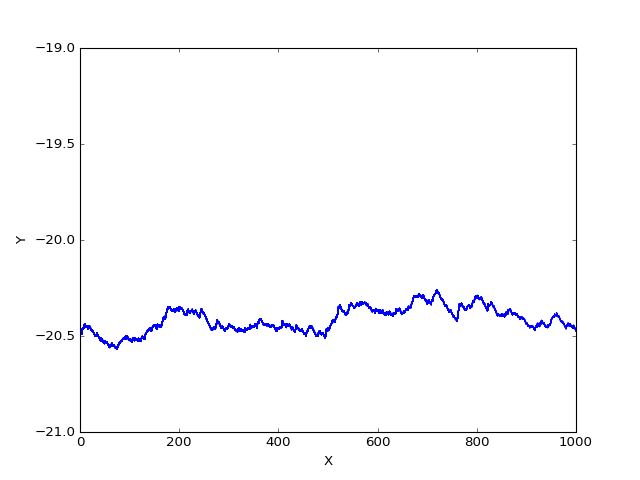

episode 0: starting up...
ep: 0, reward: -21.0, mean reward: -20.485200
	ep: 1, reward: -21.0
	y_hat is:  [ 0.31844577  0.39417684  0.28737745]
	ep: 2, reward: -20.0
	ep: 3, reward: -21.0
	ep: 4, reward: -18.0
	ep: 5, reward: -20.0
	y_hat is:  [ 0.28998578  0.36792362  0.34209058]
	ep: 6, reward: -20.0
	ep: 7, reward: -21.0
	ep: 8, reward: -20.0
	ep: 9, reward: -19.0
ep: 10, reward: -20.0, mean reward: -20.438235
	ep: 11, reward: -21.0
	ep: 12, reward: -21.0
	y_hat is:  [ 0.27122653  0.42047504  0.30829847]
	ep: 13, reward: -21.0
	ep: 14, reward: -20.0
	ep: 15, reward: -21.0
	ep: 16, reward: -21.0
	ep: 17, reward: -19.0
	y_hat is:  [ 0.31272689  0.37749279  0.30978033]
	ep: 18, reward: -21.0
	y_hat is:  [ 0.31730932  0.36701009  0.31568059]
	ep: 19, reward: -20.0
ep: 20, reward: -21.0, mean reward: -20.453229
	ep: 21, reward: -21.0
	ep: 22, reward: -21.0
	y_hat is:  [ 0.29132509  0.39021432  0.31846058]
	ep: 23, reward: -21.0
	ep: 24, reward: -21.0
	ep: 25, reward: -20.0
	ep: 26, rewar

KeyboardInterrupt: 

In [8]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('X') ; ax.set_ylabel('Y')
ax.set_xlim(0,1000) ; ax.set_ylim(-21,-19)
pxs, pys = [], []

print 'episode {}: starting up...'.format(episode_number)
while True:
#     if True: env.render()

    # preprocess the observation
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(n_obs)
    prev_x = cur_x

    # stochastically sample a policy from the network
    action = agent.act(np.reshape(x, (1,-1)))

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action + 1)
    agent.rs.append(reward)
    reward_sum += reward
    
    if done:
        running_reward = running_reward * 0.99 + reward_sum * 0.01
        agent.learn()

        # visualization
        pxs.append(episode_number)
        pys.append(running_reward)
        if episode_number % 10 == 0:
            print 'ep: {}, reward: {}, mean reward: {:3f}'.format(episode_number, reward_sum, running_reward)
            plt_dynamic(pxs, pys, ax)
        else:
            print '\tep: {}, reward: {}'.format(episode_number, reward_sum)
            
#         if episode_number % 50 == 0:
#             saver.save(agent.sess, save_path, global_step=agent.global_step)
#             print "SAVED MODEL #{}".format(agent.global_step)
        
        # lame stuff
        cur_x = None
        episode_number += 1 # the Next Episode
        observation = env.reset() # reset env
        reward_sum = 0

In [9]:
saver.save(agent.sess, save_path, global_step=agent.global_step)

'rnn_models/model.ckpt-1085'

In [10]:
print agent.aprob
print agent.batch_aprob

AttributeError: Agent instance has no attribute 'aprob'